In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition, manifold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

# Load Data

Calculate means and standard deviations over each channel in the training set 

In [3]:
ROOT = '.data'
train_data = datasets.CIFAR10(root=ROOT,
                              train=True,
                              download=True)

means = train_data.data.mean(axis=(0,1,2)) / 255
stds = train_data.data.std(axis=(0,1,2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

100%|██████████| 170498071/170498071 [03:00<00:00, 946446.37it/s] 


Extracting .data\cifar-10-python.tar.gz to .data
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


Apply transform to train and test set 

In [4]:

train_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=means,
                         std=stds)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=means,
                         std=stds)
])

In [5]:
train_data = datasets.CIFAR10(root=ROOT,
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = datasets.CIFAR10(root=ROOT,
                             train=False,
                             download=True,
                             transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


Split data into train, validation, and test set 

In [6]:
VALID_RATIO = 0.9
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [7]:
print('Number of training examples:', len(train_data))
print('Number of validation examples:', len(valid_data))
print('Number of test examples:', len(test_data))

Number of training examples: 45000
Number of validation examples: 5000
Number of test examples: 10000


In [8]:
print('Shape of an image: ', train_data[0][0].shape) 
# train_data[0] is a tuple of image and label

Shape of an image:  torch.Size([3, 32, 32])


Function to plot image and rescale pixel values to the range [0,1] for proper rendering

In [9]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min=image_min, max=image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image


def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize=(7,7))

  for i in range(n_images):
    ax = fig.add_subplot(rows, cols, i+1)
    image = images[i]
    if normalize:
      image = normalize_image(image)
    ax.imshow(image.permute(1,2,0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

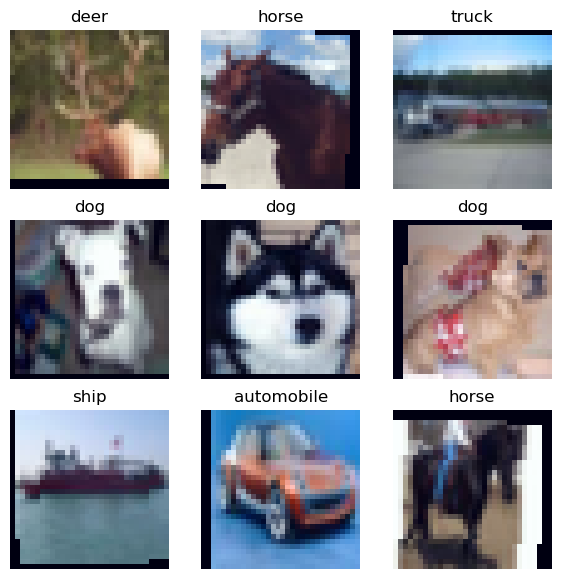

In [10]:
N_IMAGES = 9

images, labels = zip(*[(image, label) for image, label 
                       in [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

# Configure Model

Create class VGG for the family of VGG models

In [11]:
class VGG(nn.Module):
  def __init__(self, features, output_dim):
    super().__init__()

    self.features = features

    self.avgpool = nn.AdaptiveAvgPool2d(7)

    self.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, output_dim),
    )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    h = x.view(x.shape[0], -1)
    output = self.classifier(h)
    return output, h

Configuration for VGG16: 
- the numbers denote the number of channels in each layer
- 'M' denotes max pooling
 Налаштування для VGG16:
- цифри позначають кількість каналів в кожному шарі
-'M'позначає максимальне об'єднання

In [12]:
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 
                512, 512, 512, 'M', 512, 512, 512, 'M']

In [13]:
def get_vgg_layers(config, batch_norm):
  layers = []
  in_channels = 3

  for c in config:
    assert c == 'M' or isinstance(c, int)
    if c == 'M':
      layers += [nn.MaxPool2d(2)]
    else:
      conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
      
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
      else:
        layers += [conv2d, nn.ReLU(inplace=True)]

      in_channels = c

  return nn.Sequential(*layers)

In [14]:
vgg16_layers = get_vgg_layers(vgg16_config, batch_norm=True)
vgg16_layers

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [15]:
OUTPUT_DIM = 10
model = VGG(vgg16_layers, OUTPUT_DIM)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Train Model

Setup dataloader and hyperparameters

In [16]:
BATCH_SIZE = 128

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE)

In [17]:
LR = 3e-4

optimizer = optim.Adam(model.parameters(), lr= LR)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [18]:
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(axis=1, keepdims=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

In [19]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0
  model.train()
  for (x,y) in tqdm(iterator, desc='Training', leave=False):
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    y_pred, _ = model(x)
    loss = criterion(y_pred, y)
    acc = calculate_accuracy(y_pred, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()

  with torch.no_grad():
    for (x, y) in tqdm(iterator, desc='Evaluating', leave=False):
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred, y)
      acc = calculate_accuracy(y_pred, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_min = int(elapsed_time/60)
  elapsed_secs = int(elapsed_time - elapsed_min * 60)
  return elapsed_min, elapsed_secs

In [23]:
EPOCHS= 40
best_valid_loss = float('inf')

for epoch in trange(EPOCHS):
  start_time = time.monotonic()

  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'vgg16-model.pt')

  end_time = time.monotonic()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 16m 58s
	Train Loss: 0.952 | Train Acc: 67.60%
	Val. Loss: 1.056 | Val. Acc: 65.53%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 17m 1s
	Train Loss: 0.862 | Train Acc: 71.18%
	Val. Loss: 0.877 | Val. Acc: 70.27%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 16m 52s
	Train Loss: 0.774 | Train Acc: 74.78%
	Val. Loss: 0.737 | Val. Acc: 76.78%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 16m 57s
	Train Loss: 0.715 | Train Acc: 76.88%
	Val. Loss: 0.695 | Val. Acc: 79.39%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 17m 12s
	Train Loss: 0.663 | Train Acc: 78.95%
	Val. Loss: 0.705 | Val. Acc: 78.87%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 17m 27s
	Train Loss: 0.619 | Train Acc: 80.56%
	Val. Loss: 0.633 | Val. Acc: 81.21%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 17m 27s
	Train Loss: 0.587 | Train Acc: 81.43%
	Val. Loss: 0.654 | Val. Acc: 79.96%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 17m 30s
	Train Loss: 0.552 | Train Acc: 82.67%
	Val. Loss: 0.628 | Val. Acc: 82.38%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 17m 14s
	Train Loss: 0.532 | Train Acc: 83.31%
	Val. Loss: 0.586 | Val. Acc: 83.11%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 17m 4s
	Train Loss: 0.623 | Train Acc: 80.49%
	Val. Loss: 0.834 | Val. Acc: 75.96%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 17m 11s
	Train Loss: 0.506 | Train Acc: 84.21%
	Val. Loss: 0.571 | Val. Acc: 82.30%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 17m 22s
	Train Loss: 0.490 | Train Acc: 84.73%
	Val. Loss: 0.549 | Val. Acc: 84.22%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 17m 21s
	Train Loss: 0.484 | Train Acc: 85.01%
	Val. Loss: 0.623 | Val. Acc: 81.00%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 17m 0s
	Train Loss: 0.440 | Train Acc: 86.23%
	Val. Loss: 0.527 | Val. Acc: 83.32%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 16m 55s
	Train Loss: 0.514 | Train Acc: 84.23%
	Val. Loss: 0.715 | Val. Acc: 77.97%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 16m 37s
	Train Loss: 0.427 | Train Acc: 86.53%
	Val. Loss: 0.444 | Val. Acc: 86.45%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 16m 56s
	Train Loss: 0.386 | Train Acc: 87.69%
	Val. Loss: 0.430 | Val. Acc: 86.80%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 16m 50s
	Train Loss: 0.375 | Train Acc: 88.56%
	Val. Loss: 3.532 | Val. Acc: 32.03%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 16m 52s
	Train Loss: 0.576 | Train Acc: 82.64%
	Val. Loss: 0.584 | Val. Acc: 81.46%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 16m 52s
	Train Loss: 0.411 | Train Acc: 87.11%
	Val. Loss: 0.454 | Val. Acc: 86.13%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 16m 45s
	Train Loss: 0.415 | Train Acc: 87.21%
	Val. Loss: 0.421 | Val. Acc: 87.27%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 16m 41s
	Train Loss: 0.422 | Train Acc: 86.92%
	Val. Loss: 0.418 | Val. Acc: 86.56%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 16m 50s
	Train Loss: 0.319 | Train Acc: 89.86%
	Val. Loss: 0.384 | Val. Acc: 88.20%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 16m 50s
	Train Loss: 0.385 | Train Acc: 88.81%
	Val. Loss: 0.459 | Val. Acc: 85.59%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 16m 51s
	Train Loss: 0.337 | Train Acc: 89.50%
	Val. Loss: 0.411 | Val. Acc: 87.29%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 16m 52s
	Train Loss: 0.293 | Train Acc: 90.67%
	Val. Loss: 0.401 | Val. Acc: 87.38%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 16m 50s
	Train Loss: 0.297 | Train Acc: 90.69%
	Val. Loss: 0.386 | Val. Acc: 87.93%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 16m 49s
	Train Loss: 0.261 | Train Acc: 91.61%
	Val. Loss: 0.382 | Val. Acc: 88.18%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 17m 3s
	Train Loss: 0.254 | Train Acc: 91.92%
	Val. Loss: 0.357 | Val. Acc: 88.44%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 17m 10s
	Train Loss: 0.275 | Train Acc: 91.33%
	Val. Loss: 0.641 | Val. Acc: 80.21%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: 16m 50s
	Train Loss: 0.291 | Train Acc: 90.97%
	Val. Loss: 0.392 | Val. Acc: 87.09%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 16m 56s
	Train Loss: 0.242 | Train Acc: 92.38%
	Val. Loss: 0.356 | Val. Acc: 88.59%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: 16m 50s
	Train Loss: 0.236 | Train Acc: 92.62%
	Val. Loss: 0.367 | Val. Acc: 88.36%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 17m 8s
	Train Loss: 0.243 | Train Acc: 92.15%
	Val. Loss: 0.447 | Val. Acc: 85.98%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: 16m 49s
	Train Loss: 0.228 | Train Acc: 92.76%
	Val. Loss: 0.362 | Val. Acc: 88.07%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 16m 49s
	Train Loss: 0.202 | Train Acc: 93.48%
	Val. Loss: 0.328 | Val. Acc: 89.59%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: 16m 51s
	Train Loss: 0.330 | Train Acc: 90.22%
	Val. Loss: 0.414 | Val. Acc: 87.58%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 16m 52s
	Train Loss: 0.517 | Train Acc: 84.72%
	Val. Loss: 0.660 | Val. Acc: 79.92%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: 16m 50s
	Train Loss: 0.313 | Train Acc: 89.90%
	Val. Loss: 0.362 | Val. Acc: 88.07%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 16m 56s
	Train Loss: 0.252 | Train Acc: 92.06%
	Val. Loss: 0.382 | Val. Acc: 88.46%


Load the saved model from training and evaluate on test set

In [24]:
model.load_state_dict(torch.load('vgg16-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test loss: {test_loss:.3f} | Test accuracy: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 0.344 | Test accuracy: 89.39%


# Result Analysis

In [25]:
def plot_image(image):
  """
  image -- tensor of shape (C,H,W)
  """
  image = copy.deepcopy(image)
  image = normalize_image(image)
  fig = plt.figure(figsize=(5,5))
  ax = fig.add_subplot(1,1,1)
  ax.imshow(image.permute(1,2,0).cpu().numpy())
  ax.axis('off')

Function to predict the class of a single image

In [26]:
def predict(image):
  """
  image -- tensor of shape (C,H,W)
  """
  image = copy.deepcopy(image)

  model.eval()
  with torch.no_grad():
    image = image.unsqueeze(0)
    image = image.to(device)
    pred_label, _ = model(image)
    pred_probs = F.softmax(pred_label, dim=-1)
    pred_value, pred_id = torch.max(pred_probs, dim=-1)
  return pred_value, pred_id

True label: truck
Pred. label: truck (99.611%)


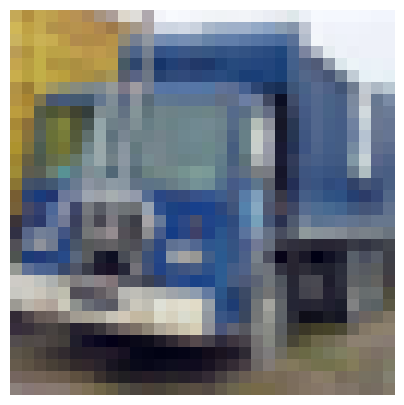

In [27]:
idx = 14

image, label = test_data[idx]

plot_image(image)

pred_value, pred_id = predict(image)

print(f'True label: {classes[label]}')
print(f'Pred. label: {classes[pred_id.item()]} ({pred_value.item()*100:.3f}%)')

In [28]:
def get_predictions(model, iterator, device):
  model.eval()
  images = []
  labels = []
  probs = []

  with torch.no_grad():
    for (x,y) in iterator:
      x = x.to(device)
      y_pred, _ = model(x)
      y_prob = F.softmax(y_pred, dim=-1)
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())

  images = torch.cat(images, dim=0)
  labels = torch.cat(labels, dim=0)
  probs = torch.cat(probs, dim=0)
  
  return images, labels, probs

In [29]:
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, dim=1)

In [30]:
def plot_confusion_matrix(labels, pred_labels, classes):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1,1,1)
  cm = confusion_matrix(labels, pred_labels)
  cm = ConfusionMatrixDisplay(cm, display_labels=classes)
  cm.plot(values_format='d', cmap='Blues', ax=ax)
  plt.xticks(rotation=20)

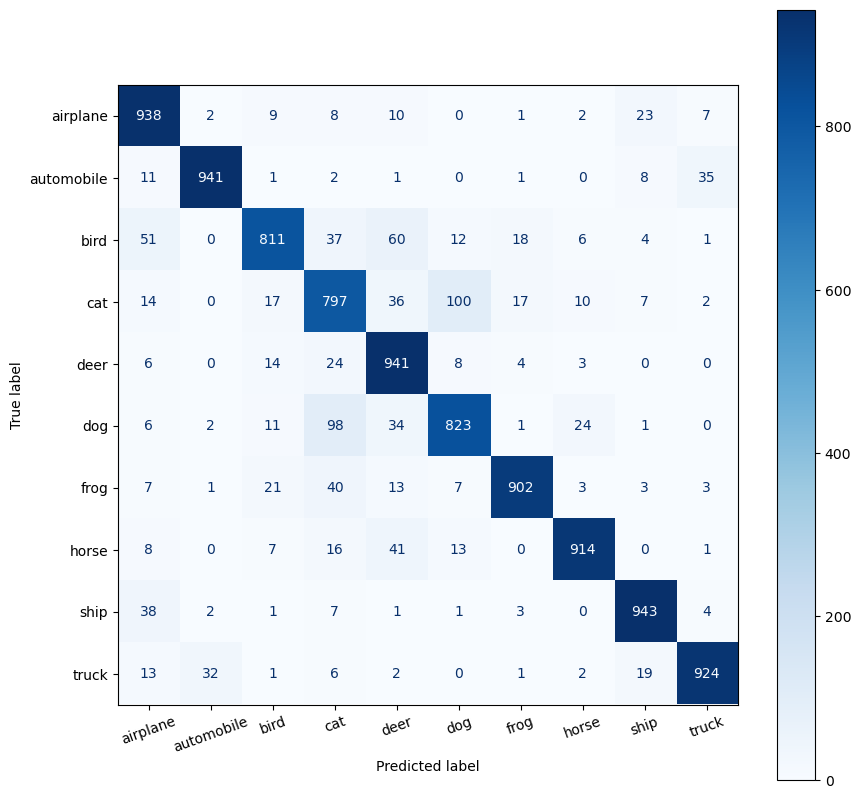

In [31]:
plot_confusion_matrix(labels, pred_labels, classes)

In [32]:
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
  if not correct:
    incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key = lambda x : torch.max(x[2], dim=0).values) # x[2] is prob

Function to plot incorrect predictions. Notice that the model can be very confidence with its prediction even when that prediction is wrong

In [33]:
def plot_most_incorrect(incorrect, classes, n_images, normalize=True):
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize=(25,20))

  for i in range(n_images):
    ax = fig.add_subplot(rows, cols, i+1)
    image, true_label, probs = incorrect[i]
    image = image.permute(1,2,0)
    true_prob = probs[true_label]
    incorrect_prob, incorrect_label = torch.max(probs, dim=0) 
    # needs 'dim=0' to return both value and index
    true_class = classes[true_label]
    incorrect_class = classes[incorrect_label]

    if normalize:
      normalize_image(image)

    ax.imshow(image.cpu().numpy())
    ax.set_title(f'True label: {true_class} ({true_prob:.3f})\n'
                f'Pred. label: {incorrect_class} ({incorrect_prob:.3f})')
    ax.axis('off')

  fig.subplots_adjust(hspace=0.4)

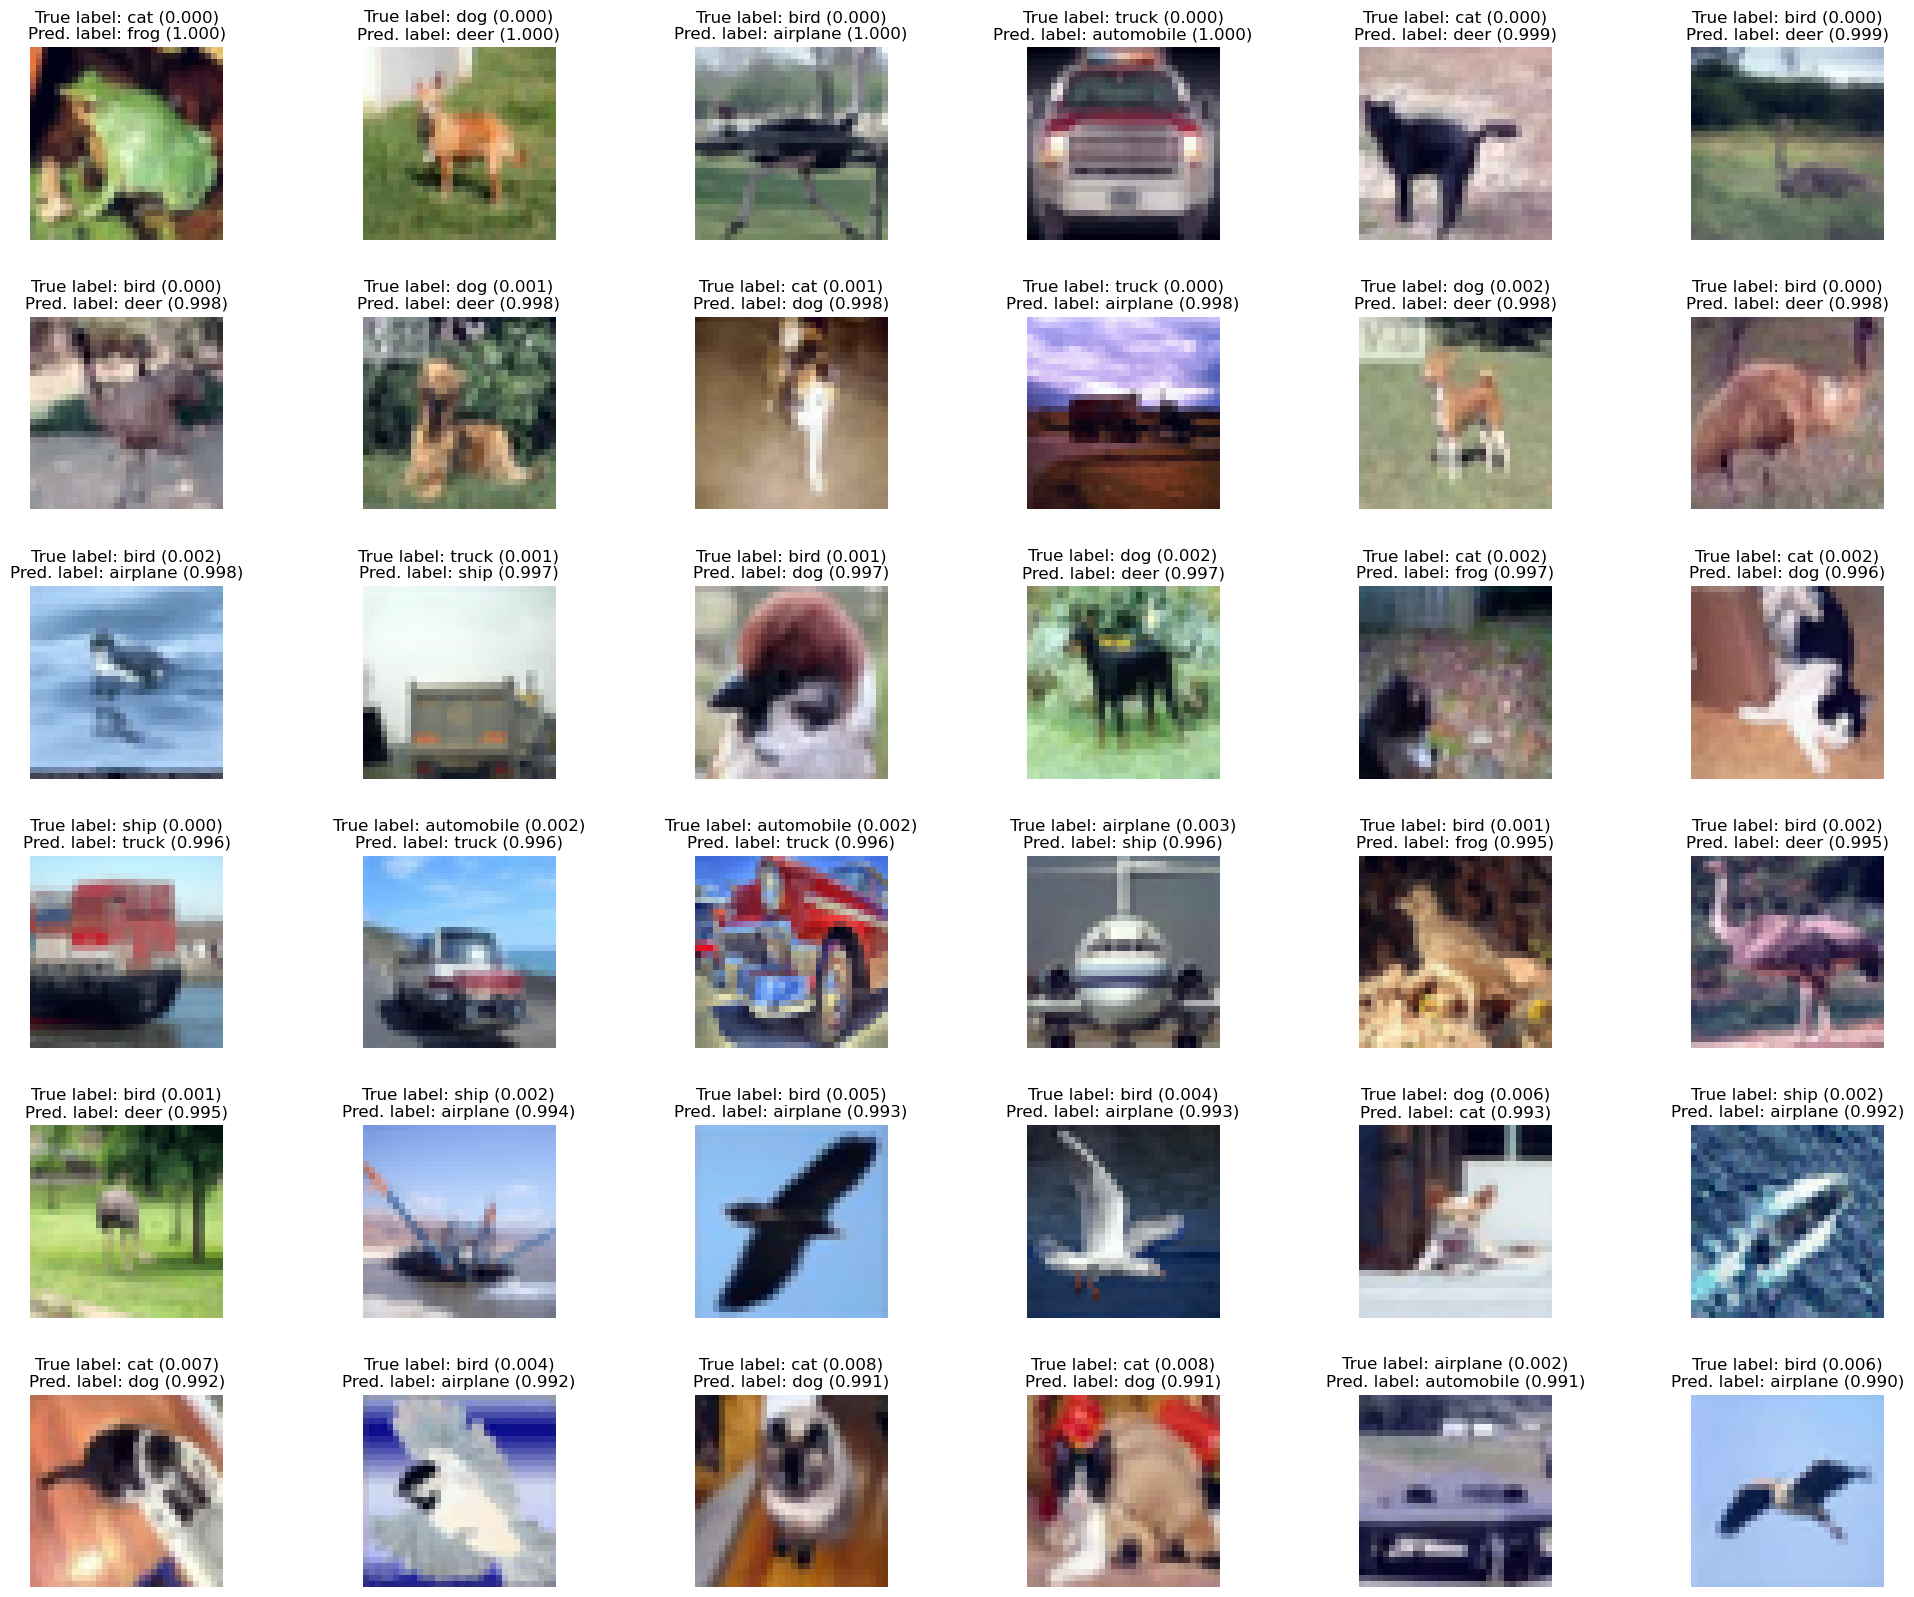

In [34]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)